/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM
load frame  0
load frame  60
load frame  120
load frame  180
load frame  240
elapsed 36.64059591293335


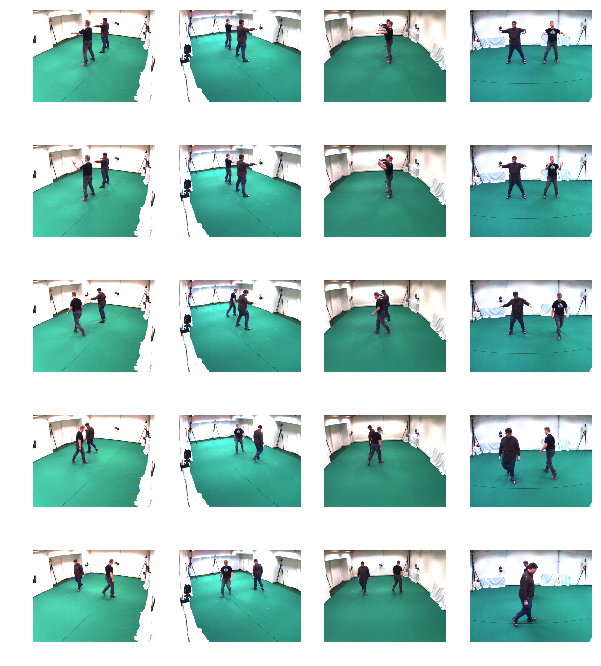

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np
import cv2
from cselect import color as cs
from time import time

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']
tmp = Settings['tmp']

_start = time()
X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

# **************************** #
FRAMES = [0, 60, 120, 180, 240]
# **************************** #

def get_track(FRAMES):
    Ims = []
    Hms = []
    Pafs = []
    for frame in FRAMES:
        print('load frame ', frame)
        Im = np.array([X[0][frame], X[1][frame], X[2][frame], X[3][frame]])
        Ims.append(Im)
        heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', 
                                                            Im, 
                                                            frame, 
                                                            dir=tmp)
        Hms.append(heatmaps)
        Pafs.append(pafs)

    Ims = np.array(Ims)
    Hms = np.array(Hms)
    Pafs = np.array(Pafs)
    return Ims, Hms, Pafs

Ims, Hms, Pafs = get_track(FRAMES)
_end = time()
print('elapsed', _end - _start)

fig = plt.figure(figsize=(10,12))
n = len(FRAMES)
for frame, Im in enumerate(Ims):
    for cid in range(4):
        ax = fig.add_subplot(n, 4, frame*4+cid+1)
        ax.axis('off')
        ax.imshow(Im[cid])

plt.show()

handling frame  0
elapsed 2.910170316696167
handling frame  1
elapsed 2.6603822708129883
handling frame  2
elapsed 2.795707941055298
handling frame  3
elapsed 3.00089430809021
handling frame  4
elapsed 2.6554014682769775
elapsed 14.024358034133911


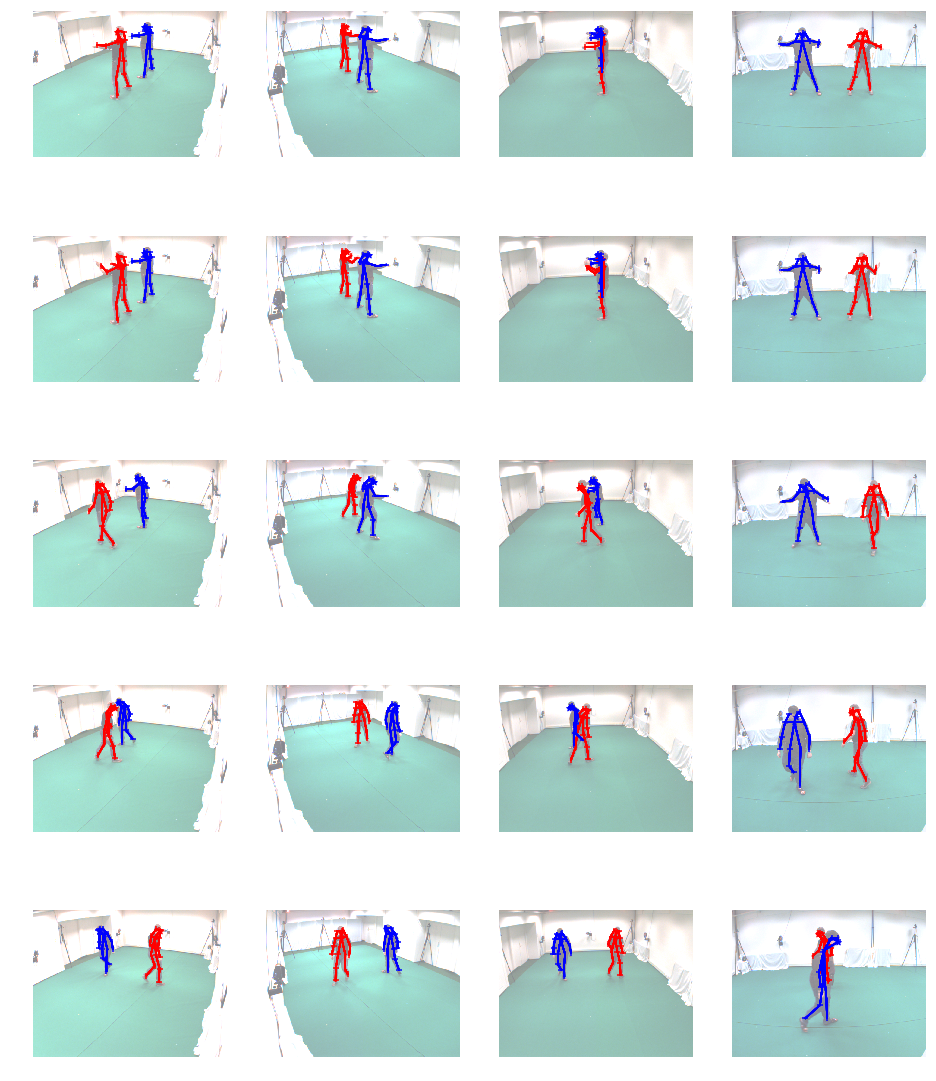

In [2]:
from mvpose.tracking import track
from mvpose.plot.limbs import draw_mscoco_human

# =============================
_start = time()
Debug = track([Calib], Hms, Pafs, debug=True)
_end = time()
print('elapsed', _end - _start)
# =============================

n_frames = Debug.n_frames
n_joints = Debug.n_joints

colors = cs.lincolor(22)/255

fig = plt.figure(figsize=(16,20))

colors = ['red', 'blue', 'green']

_ct = 1
for frame, (Humans, Im) in enumerate(zip(Debug.humans, Ims)):
    for cid, cam in enumerate(Calib):
        h,w,_ = Im[cid].shape
        ax = fig.add_subplot(n_frames, 4, _ct); ax.axis('off')
        ax.set_xlim([0, w])
        ax.set_ylim([h, 0])
        _ct += 1; ax.imshow(Im[cid], alpha=0.5)
        
        for pid, human in enumerate(Humans):
            draw_mscoco_human(ax, human, cam, color=colors[pid])


plt.show()

In [4]:
for t1, t2 in zip(range(0, n_frames -1), range(1, n_frames)):
    print(t1, t2)

0 1
1 2
2 3
3 4
